<img src="logo.png">

# Confianza en las autoridades 

En la ENVIPE 2022, dentro de la tabla ``tper_vic.RData``, en las columnas ``AP5_3_X``, con ``X`` tomando los valores 01, 02, 03,..., 10, se le pregunta al encuestado si reconoce a la autoridad ``X``, donde las autoridades se indican más abajo.

En caso de respuesta afirmativa (valor 1), se le procede a preguntar si considera que la autoridad ``X`` es o no corrupta, siendo 1 la respuesta "Sí".

El problema consiste en, para cada autoridad, generar una gráfica del mapa político de México coloreando cada entidad mediante el porcentaje de personas que reconocen dicha autoridad y la consideran corrupta respecto del total del personas que la reconocen.

**NOTA.** En Tlaxcala no existe autoridad de Tránsito Municipal, así como en Ciudad de México no existe autoridad de Policía Municipal.

In [1]:
# Mostramos las autoridades por las cuales se pregunta a los encuestados
descripcion_autoridades = c("Tránsito municipal",
                            "Policía municipal",
                            "Policía Estatal",
                            "Guardia Nacional",
                            "Policía Ministerial",
                            "Ministerio_Público\nFiscalías",
                            "FGR",
                            "Ejército",
                            "Marina",
                            "Jueces")

## Lectura de la tabla de interés

Como primeros pasos, leemos la tabla de nuestro interés y la preparamos para comenzar a trabajar.

In [2]:
# Cargamos nuestra paquetería.
library(tidyverse)

# Cargamos la tabla que contiene la información donde se encuentran las columnas de interés.
load("tper_vic.RData")

# De la tabla cargada, seleccionamos únicamente las columnas de nuestro interés:
##### CVE_ENT: clave de la entidad.
##### Familia AP5_03_X: reconocimiento de la autoridad.
##### Familia AP5_05_X: percepción de la autoridad acerca de la corrupción.
##### FAC_ELE: factor de elección.

corrupcion <- tper_vic %>% select(CVE_ENT,
                                  AP5_3_01,AP5_3_02,AP5_3_03,AP5_3_04,AP5_3_05,AP5_3_06,AP5_3_07,AP5_3_08,AP5_3_09,AP5_3_10,
                                  AP5_5_01,AP5_5_02,AP5_5_03,AP5_5_04,AP5_5_05,AP5_5_06,AP5_5_07,AP5_5_08,AP5_5_09,AP5_5_10,
                                  FAC_ELE)

Warning message:
"package 'tidyverse' was built under R version 3.6.3"-- Attaching packages ------------------------------------------------------------------------------- tidyverse 1.3.1 --
v ggplot2 3.3.5     v purrr   0.3.4
v tibble  3.1.1     v dplyr   1.0.6
v tidyr   1.1.3     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.1
Warning message:
"package 'ggplot2' was built under R version 3.6.3"Warning message:
"package 'tibble' was built under R version 3.6.3"Warning message:
"package 'tidyr' was built under R version 3.6.3"Warning message:
"package 'readr' was built under R version 3.6.3"Warning message:
"package 'purrr' was built under R version 3.6.3"Warning message:
"package 'dplyr' was built under R version 3.6.3"Warning message:
"package 'stringr' was built under R version 3.6.3"Warning message:
"package 'forcats' was built under R version 3.6.3"-- Conflicts ---------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::

## Estrategia de trabajo y creación de funciones auxiliares

Para cada autoridad, extraeremos la subtabla formada por las columnas ``CVE_ENT``, ``AP5_03_X``, ``AP5_05_X`` y ``FAC_ELE``. Esto lo haremos con la función ``extraer()``, la cual se aplicará cada uno de los números del 2 al 11 (que son los índices de las columnas de reconocimiento dentro de la tabla ``corrupcion``), de modo que nos devolverá una lista con cada subtabla a la que llamaremos ``autoridades``.

Por otra parte, crearemos una función que reciba como argumento cualquier tabla que contenga columnas ``reconocimiento``, ``corrupcion`` y ``FAC_ELE``, y nos diga el porcentaje de personas que consideran que hay corrupción dentro de las que reconozcan a la autoridad en cuestión. Esto lo haremos con la función ``resumen()``.

Finalmente, mediante una función que reciba como argumento un número ``x`` del 1 al 10, tomaremos el elemento ``x`` de la lista ``autoridades``, lo agruparemos por entidad y aplicaremos la función ``resumen()`` a cada uno de los grupos, además de añadir una columna con el nombre de la autoridad en cuestión y cambiar el nombre de la columna ``CVE_ENT`` por ``ent`` (mas adelante veremos el porqué de cambiar este nombre). Esto lo haremos con la función ``calcular_por_autoridad``.

De esta manera, obtendremos una lista a la que llamaremos ``tablas_autoridades`` formada por 10 tablas: una por cada autoridad, y en donde cada tabla contiene una columna ``ent`` con los números del 1 al 32, el porcentaje de personas que piensan que la autoridad en cuestión es corrupta, y el nombre de la autoridad en cuestión. Finalmente, pegaremos las 10 tablas verticalmente.

In [3]:
extraer <- function(x){
    auxiliar = corrupcion[,c(1,x,x+10,22)]
    names(auxiliar)[2:3] = c("reconocimiento","corrupcion")
    return(auxiliar)
}

autoridades <- lapply(2:11,extraer)

In [4]:
resumen  <- function(tabla){ 
    auxiliar = tabla %>% 
        filter(reconocimiento == 1) %>%
        mutate(corrupcion = ifelse(corrupcion==1,1,0)) %>%
        summarize(porcentaje_corrupcion = sum(corrupcion*FAC_ELE)*100/sum(FAC_ELE))
    return(auxiliar)
}

In [5]:
estatal_calcular_por_autoridad <- function(x){
    autoridades[[x]] %>% 
        group_by(CVE_ENT) %>% 
        resumen() %>%
        ungroup() %>%
        mutate(autoridad = descripcion_autoridades[x]) %>%
        rename(ent=CVE_ENT)
}

In [6]:
estatal_tablas_autoridades = lapply(1:10,estatal_calcular_por_autoridad)
estatal_tabla_corrupcion_final = do.call(rbind,estatal_tablas_autoridades)

## Armado del dataframe para graficar

Leeremos la información que requerimos para hacer cada mapa. Esta la tenemos en la tabla ``Mexico_division_politica.csv``. En su columna ``Grupo`` tenemos un número con decimales, donde la parte entera representa a la entidad a la que las coordenadas ``Latitud`` y ``Longitud`` pertenecen. Crearemos una nueva tabla llamada ``mex`` que incluya, además de toda la información de ``Mexico_division_politica.csv``, una columna ``ent`` con la entidad a la cual pertenecen las coordenadas.

Posteriormente, crearemos una tabla llamada ``mapa`` llevando la información de la tabla ``tabla_corrupción_final`` hacia la tabla ``mex`` mediante las columnas ``ent`` de ambas, de modo que ``mapa`` tendrá las coordenadas geográficas, la entidad a la que pertencen las coordenas, el porcentaje de percepción de corrupción y la autoridad a la que se refiere ese porcentaje.

In [7]:
mexico_div <- read.csv("Mexico_division_politica.csv")
mex <- mexico_div %>% mutate(ent = as.integer(Grupo))
mapa = left_join(mex,estatal_tabla_corrupcion_final)

Joining, by = "ent"


## Graficación

Finalmente, graficamos coloreando cada entidad por el porcentaje de corrupción y faceteando por autoridad.

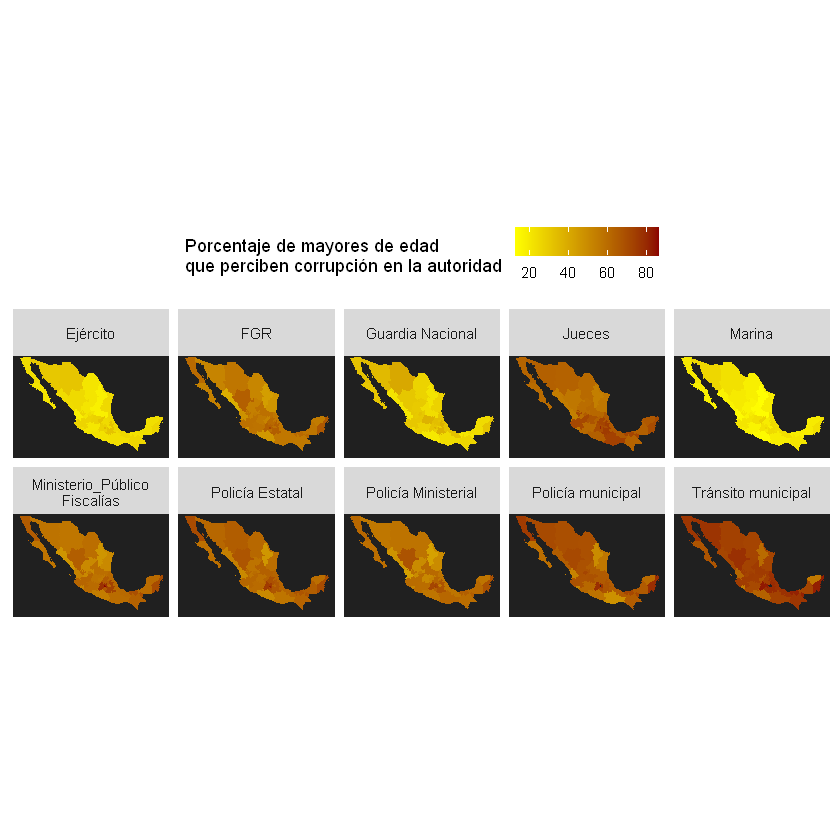

In [8]:
ggplot() +
  geom_polygon(data = mapa,
               mapping = aes(x=Longitud,
                                   y=Latitud,
                                   group=Grupo,
                                   fill=porcentaje_corrupcion),
               size = .05) +
  scale_fill_gradient(low = "yellow",
                      high = "darkred",
                      na.value = NA,
                      name="Porcentaje de mayores de edad\nque perciben corrupción en la autoridad") +
  coord_map(xlim=c(-117,-87),
            ylim=c(14,32)) +
  theme(legend.position="top",
    panel.background = element_rect("#202020"), 
    panel.grid = element_blank(),
    axis.title = element_blank(), 
    axis.text = element_blank(), 
    axis.ticks = element_blank()
  ) +
  facet_wrap(.~autoridad,ncol=5) 